In [23]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [24]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [25]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct, desc

In [26]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

### Explore the Database

In [27]:
# Use Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [28]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [29]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [30]:
# Use `engine.execute` to select and display the first 2 rows from each table
engine.execute('SELECT * FROM measurement LIMIT 2').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0)]

In [31]:
# Use `engine.execute` to select and display the rows from each table
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [32]:
# reflect an existing database into a new model
Base = automap_base()
# Reflect Database into ORM class
# reflect the tables
Base.prepare(engine, reflect=True)


In [33]:
# View all of the classes that automap found (should be the same as what was listed by inspect)
Base.classes.keys()

['measurement', 'station']

In [34]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [35]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [36]:
# Find the most recent date in the Measurement table.
maxdate = session.query(func.max(Measurement.date)).all() 

print(f"The most recent date is {maxdate[0][0]}")

The most recent date is 2017-08-23


The most recent date is 2017-08-23
The starting date for full year of data preceding last date is: 2016-08-23

 Line plot for Precipitation by Date 
 



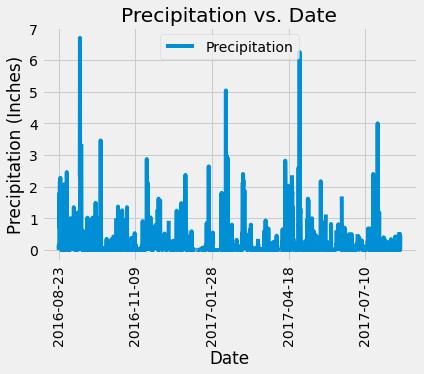

In [37]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Find the most recent date in the Measurement table.
# note: the most recent data was found above....and is in maxdate

print(f"The most recent date is {maxdate[0][0]}")

# Calculate the date one year from the last date in data set.
# convert the string to a datetime obj

date_time_obj = dt.datetime.strptime(maxdate[0][0],'%Y-%m-%d').date()

# Calculate the predecing year before the max date as the starting point...so minus 365
year_earlier = date_time_obj - dt.timedelta(days=365) 
print("The starting date for full year of data preceding last date is:", year_earlier)

# Perform a query to retrieve the data and precipitation scores

plot_precip_list = session.query(Measurement.date, Measurement.prcp.label("Precipitation")).\
    filter(Measurement.date >= year_earlier).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
plot_precip_df =pd.DataFrame(plot_precip_list).set_index("date").sort_values(by="date")

# Use Pandas Plotting with Matplotlib to plot the data

Line_Chart = plot_precip_df.plot(y="Precipitation",title="Precipitation vs. Date")
Line_Chart.set_ylabel("Precipitation (Inches)")
Line_Chart.set_xlabel("Date")
Line_Chart.tick_params(axis='x', labelrotation=90, )

print(f"\n Line plot for Precipitation by Date \n \n")
plt.show()


In [38]:
# Use Pandas to calculate the summary statistics for the precipitation data
plot_precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [39]:
# Design a query to calculate the total number stations in the dataset
station_count_meas = session.query(Measurement.station).distinct(Measurement.station).count() 

print(f"The count of unique stations in the Measurement table is {station_count_meas}")

# Design a query to calculate the total number stations in the dataset
station_count_station = session.query(Station.station).distinct(Station.station).count() 

print(f"The count of unique stations in the Station table is {station_count_station}")

The count of unique stations in the Measurement table is 9
The count of unique stations in the Station table is 9


In [40]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

station_obs_df = pd.DataFrame(session.query(Measurement.station.label("Station"), func.count(Measurement.station).label("Observations")).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()) 


 
print(f"The descending list of stations with the most to least observations in the Measurement table are: \n")
print(station_obs_df.head(10))
print("\n \n")
print(f"The station with the most observations in the Measurement table is: \n")
print(station_obs_df.head(1))



The descending list of stations with the most to least observations in the Measurement table are: 

       Station  Observations
0  USC00519281          2772
1  USC00519397          2724
2  USC00513117          2709
3  USC00519523          2669
4  USC00516128          2612
5  USC00514830          2202
6  USC00511918          1979
7  USC00517948          1372
8  USC00518838           511

 

The station with the most observations in the Measurement table is: 

       Station  Observations
0  USC00519281          2772


In [41]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# reusing the query from above with the ".first" we build the subquery for the filter....
subquery = session.query(Measurement.station.label("Station")).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).first() 

# this is the main query to calculate the min, max, avg with func... 
query_df = pd.DataFrame(session.query(Measurement.station.label("Station"), \
        func.min(Measurement.tobs).label("Minimum Temperature"), \
        func.max(Measurement.tobs).label("Maximum Temperature"), \
        func.avg(Measurement.tobs).label("Average Temperature")).\
        filter(Measurement.station.in_(subquery)).all()) 



In [42]:
print(query_df)

       Station  Minimum Temperature  Maximum Temperature  Average Temperature
0  USC00519281                 54.0                 85.0            71.663781


In [43]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Part 1 - calculate the correct date  
# Find the most recent date in the Measurement table for that station....
max_most_obs_date = session.query(func.max(Measurement.date)).filter(Measurement.station.in_(subquery)).all() 
# and output it for reference
print(f"The most recent date for {subquery[0]} is {max_most_obs_date[0][0]} \n\n")

# Calculate the date one year from the last date in data set.
# convert the string to a datetime obj

most_date_time_obj = dt.datetime.strptime(max_most_obs_date[0][0],'%Y-%m-%d').date()
print(most_date_time_obj)

# Calculate the predecing year before the max date as the starting point...so minus 365
most_year_earlier = most_date_time_obj - dt.timedelta(days=365) 
print(f"The starting date for full year of data preceding last date for station {subquery[0]} is:", most_year_earlier)


The most recent date for USC00519281 is 2017-08-18 


2017-08-18
The starting date for full year of data preceding last date for station USC00519281 is: 2016-08-18



 Histogram for Frequency of Observations for Temperature for Station USC00519281
 



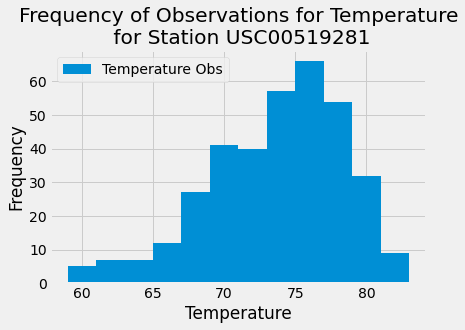

In [44]:
# now select the data as done previously, but now for temperature, the new earlier date and using the station as an extra filter....
# Perform a query to retrieve the data and precipitation scores

plot_temp_list = session.query(Measurement.date, Measurement.tobs.label("Temperature")).\
    filter(Measurement.date >= most_year_earlier).filter(Measurement.station.in_(subquery)).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
plot_temp_df =pd.DataFrame(plot_temp_list).set_index("date").sort_values(by="date")

# Use Pandas Plotting with Matplotlib to plot the data

Hist_Chart = plot_temp_df.plot.hist(bins=12,label="Temperature Obs", y="Temperature",title=f"Frequency of Observations for Temperature\n for Station {subquery[0]}")
Hist_Chart.set_ylabel("Frequency")
Hist_Chart.set_xlabel("Temperature")

print(f"\n Histogram for Frequency of Observations for Temperature for Station {subquery[0]}\n \n")
plt.show()


# Close session

In [45]:
# Close Session
session.close()